In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sentinelhub import SHConfig
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
import folium
from tqdm import tqdm
import math

In [2]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
from sentinelhub import CRS, BBox, bbox_to_dimensions
import cv2
import ee

In [3]:
config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))

In [4]:
evalscript_lsm = """
function setup() {
  return {
    input: ["B02", "B03", "B04", "B08", "B11"],
    output: { bands: 3 },
  };
}

function stretch(val, min, max) { return (val - min) / (max - min); }

function evaluatePixel(sample) {
  var bsi = ((sample.B11 + sample.B04) - (sample.B08 + sample.B02)) / ((sample.B11 + sample.B04) + (sample.B08 + sample.B02));
  var NDVI = index(sample.B08, sample.B04);
  var NDWI = index(sample.B03, sample.B08);
  
  // Cloud filtering: Brightness threshold and band ratios
  var brightness = (sample.B02 + sample.B03 + sample.B04) / 3; // Visible brightness
  var cloud_ratio = sample.B11 / sample.B08; // Higher values indicate possible clouds

  if (brightness > 0.25 && cloud_ratio > 1.2) {
    return [0.8, 0.8, 0.8]; // Light gray to minimize cloud impact
  }

  // Set unavailable regions to black (e.g., non-land areas, invalid data)
  if (!isFinite(bsi) || !isFinite(NDVI) || !isFinite(NDWI) || sample.B02 === 0) {
    return [0, 0, 0]; // Black
  }

  if (NDWI > 0.15) {
    return [0, 0.2, 1.0 * NDWI];
  }
  if ((sample.B11 > 0.95) || (NDVI < 0.1)) {
    return [1.5, 0.7, -1];
  }
  //if (NDVI > 0.25) {
  //  return [0, 0.2 * NDVI, 0];
  ////} else {
  //  return [3.5 * bsi, 0.3, 0];
  //}
}
"""

In [5]:
from math import cos, radians

def add_km_to_coordinates(lat, lon, d_lat_km, d_lon_km):
    km_per_deg_lat = 111.32  # Constant
    km_per_deg_lon = 111.32 * cos(radians(lat))  # Adjusted for latitude
    
    new_lat = lat + (d_lat_km / km_per_deg_lat)  # Convert km to degrees
    new_lon = lon + (d_lon_km / km_per_deg_lon)
    
    # Ensure latitude is within -90 to 90 degrees
    if new_lat > 90:
        new_lat = 90
    elif new_lat < -90:
        new_lat = -90
    
    # Ensure longitude wraps around correctly
    new_lon = (new_lon + 180) % 360 - 180
    
    return new_lat, new_lon

In [6]:
grid = 10
box_dim = 400 #450 km
min_lat, min_lon  = 6.763053, 66.278948

# max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim, box_dim)
max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim * (grid - 1), box_dim * (grid - 1))

lat = [add_km_to_coordinates(min_lat, min_lon, i * box_dim, 0)[0] for i in range(grid)]
lon = [add_km_to_coordinates(min_lat, min_lon, 0, i * box_dim)[1] for i in range(grid)]

latlons = []
for i in range(len(lat)-1):
    for k in range(len(lon)-1):
        latlons.append((lat[k], lon[i], lat[k+1], lon[i+1]))

m = folium.Map(
    location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2],
    zoom_start=4,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)

cordinates = []
for k in latlons:
    cord = [(k[0], k[1]), (k[2], k[3])]
    cordinates.append(cord)
    folium.Rectangle(cord, color='red', fill='pink',fill_opcity=0.5).add_to(m)
m

In [7]:
def get_suseptibility_mapping(cordinates, box_dim=400, date_start = "2024-04-12", date_end = "2024-04-12"):
    min_lat, min_lon  = cordinates

    max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim, box_dim)

    cords = [min_lon, min_lat, max_lon, max_lat]

    bbox = BBox(bbox=cords, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=box_dim*1000/2300)

    request_lms_color = SentinelHubRequest(
            evalscript=evalscript_lsm,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(date_start, date_end),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=bbox,
            size=size,
            config=config_sentinel,
        )

    lms_response = request_lms_color.get_data()
    return lms_response[0]

In [8]:
fixed_cords = []
for j in range(grid-2, -1, -1):
    for i in range(grid-1):
        fixed_cords.append(list(cordinates[j + i*(grid-1)][0]))

In [ ]:
lsm_1 = cv2.resize(get_suseptibility_mapping([35.509010599712546, 66.27894800000001]), (400,400))
lsm_2 = cv2.resize(get_suseptibility_mapping([35.509010599712546, 69.89737093849098]), (400,400))

In [36]:
fixed_cords[1] , add_km_to_coordinates(fixed_cords[1][0], fixed_cords[1][1], 400, 400)

([35.509010599712546, 69.89737093849098],
 (39.102255299676614, 74.31154531988784))

In [ ]:
import math

def generate_grid(top_left_lat, top_left_lon, grid_side = 9, distance=400000):
    R = 6371000  # Earth's radius in meters
    grid = []
    
    # Convert top-left latitude to radians
    top_left_lat_rad = math.radians(top_left_lat)

    # Compute shifts in degrees
    delta_lat = (distance / R) * (180 / math.pi)
    delta_lon = (distance / (R * math.cos(top_left_lat_rad))) * (180 / math.pi)

    # Generate grid (9x9)
    for row in range(grid_side):  # Move downward
        for col in range(grid_side):  # Move right
            min_lat = top_left_lat - (row * delta_lat)  # Move south
            min_lon = top_left_lon + (col * delta_lon)  # Move east
            max_lat = min_lat + delta_lat
            max_lon = min_lon + delta_lon
            grid.append([min_lat, min_lon, max_lat, max_lon])
    
    return grid

lat, lon = 35.509010599712546, 69.89737093849098
distance = 400 * 1000  # 10 km
g = generate_grid(lat, lon, distance)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1078c6a10>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [45]:
m = folium.Map(
    location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2],
    zoom_start=4,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)
for i in range(len(g)):
    folium.Rectangle([(g[i][:2]), (g[i][2:])], color='red', fill='pink',fill_opcity=0.5).add_to(m)

m

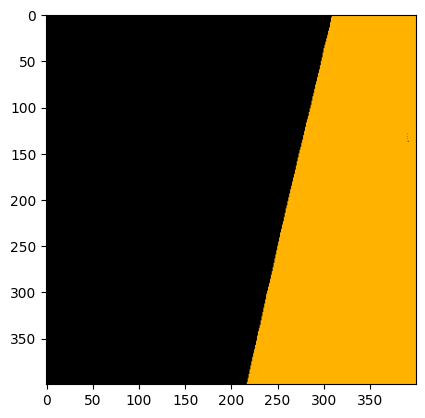

In [60]:
plt.imshow(lsm_1)

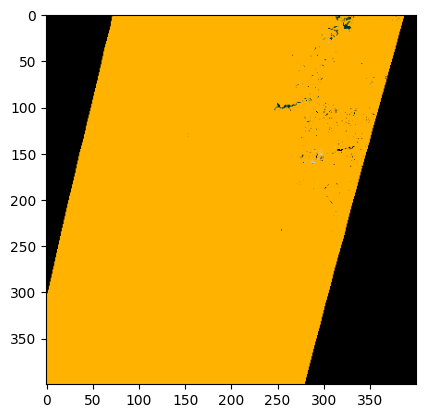

In [53]:
plt.imshow(lsm_2)

In [ ]:
canvas = np.zeros((400, 400, 3), dtype=np.uint8)

In [31]:
canvas = np.zeros(((grid-1) * box_dim, (grid-1) * box_dim, 3), dtype=np.uint8)

row = 0
col = 0

for idx, i in enumerate(range(len(fixed_cords))):

    y_start = box_dim * col
    y_end = box_dim * (col + 1)
    x_start = box_dim * row
    x_end = box_dim * (row + 1)

    print(col, row, fixed_cords[idx], "->", y_start, y_end, x_start, x_end) 
    # if row % 2 == 0:
    #     canvas[y_start:y_end, x_start:x_end] = cv2.resize(get_suseptibility_mapping([fixed_cords[idx][0], fixed_cords[idx][1]+0.3]), (400,400))
    # else:
    # canvas[y_start:y_end, x_start:x_end] = cv2.resize(get_suseptibility_mapping(fixed_cords[idx]), (400,400))
    # plt.imsave("mapping5.png", canvas)
    row += 1  # Move to the next column

    if (idx + 1) % 9 == 0:
        print("----") 
        col += 1  # Move to the next row
        row = 0  # Reset column position

0 0 [35.509010599712546, 66.27894800000001] -> 0 400 0 400
0 1 [35.509010599712546, 69.89737093849098] -> 0 400 400 800
0 2 [35.509010599712546, 73.51579387698195] -> 0 400 800 1200
0 3 [35.509010599712546, 77.13421681547294] -> 0 400 1200 1600
0 4 [35.509010599712546, 80.75263975396393] -> 0 400 1600 2000
0 5 [35.509010599712546, 84.37106269245487] -> 0 400 2000 2400
0 6 [35.509010599712546, 87.98948563094586] -> 0 400 2400 2800
0 7 [35.509010599712546, 91.60790856943686] -> 0 400 2800 3200
0 8 [35.509010599712546, 95.22633150792785] -> 0 400 3200 3600
----
1 0 [31.915765899748475, 66.27894800000001] -> 400 800 0 400
1 1 [31.915765899748475, 69.89737093849098] -> 400 800 400 800
1 2 [31.915765899748475, 73.51579387698195] -> 400 800 800 1200
1 3 [31.915765899748475, 77.13421681547294] -> 400 800 1200 1600
1 4 [31.915765899748475, 80.75263975396393] -> 400 800 1600 2000
1 5 [31.915765899748475, 84.37106269245487] -> 400 800 2000 2400
1 6 [31.915765899748475, 87.98948563094586] -> 400 8

In [30]:
len(fixed_cords)

81

In [128]:
for idx in range(81):
    if idx % (grid - 2) == 0 and idx != 0:
        print(idx)

8
16
24
32
40
48
56
64
72
80


In [ ]:
1000

In [84]:
fixed_cords

[[35.509010599712546, 66.278948],
 [35.509010599712546, 69.89737093849098],
 [35.509010599712546, 73.51579387698196],
 [35.509010599712546, 77.13421681547294],
 [35.509010599712546, 80.75263975396392],
 [35.509010599712546, 84.3710626924549],
 [35.509010599712546, 87.98948563094588],
 [35.509010599712546, 91.60790856943686],
 [35.509010599712546, 95.22633150792785],
 [31.915765899748475, 66.278948],
 [31.915765899748475, 69.89737093849098],
 [31.915765899748475, 73.51579387698196],
 [31.915765899748475, 77.13421681547294],
 [31.915765899748475, 80.75263975396392],
 [31.915765899748475, 84.3710626924549],
 [31.915765899748475, 87.98948563094588],
 [31.915765899748475, 91.60790856943686],
 [31.915765899748475, 95.22633150792785],
 [28.322521199784404, 66.278948],
 [28.322521199784404, 69.89737093849098],
 [28.322521199784404, 73.51579387698196],
 [28.322521199784404, 77.13421681547294],
 [28.322521199784404, 80.75263975396392],
 [28.322521199784404, 84.3710626924549],
 [28.32252119978440

In [81]:
fixed_cords[9]

[31.915765899748475, 66.278948]

In [80]:
len(fixed_cords)

81